<a href="https://colab.research.google.com/github/mkatogui/Prueba_tecnica/blob/main/notebooks/parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción en series temporales
Este proyecto se centra en la predicción de series temporales utilizando modelos autoregresivos con regresores. La finalidad es predecir los próximos 100 instantes de tiempo sin tener a disposición los valores de las variables regresoras para el periodo que se desea pronosticar.

## Partes del programa
1. Carga de librerías y credenciales de API
2. Selección de tema y ETL
3. Reducción de la dimensionalidad
4. Entrenamiento de los modelos
5. Selección del mejor modelo



## Comentarios de mejoras

Suponiendo que la variable a predecir es de valor y se tiene el deseo de mejorar el modelo, se puede incluir teoría económica para una mejor selección de variables y también mejorar la aplicación de los métodos estadísticos, que estos sean pertinentes con el problema a solucionar. Si todo esto está revisado, pasaremos a:

1. ***Partición de muestra: Incluir rolling windows para realizar pruebas de capacidad predictiva partiendo la muestra en entrenamiento y validación. Pudiendo ser así el 70% de la muestra y el 30% restante para validar. Otra variante que existe, es la de generar continuamente nuevos modelos e ir probando en el rolling window.*** #*HECHO*
2. Incluir el test de Diebol Mariano para probar la capacidad predictiva de los modelos y seleccionar el que mayor precisión tiene con los datos fuera de la muestra.
3. ***Incluir otras métricas, como MAPE, al igual que mejorar la utilización de MASE, donde si el dato posee estacionalidad esta se puede explicitar.*** #*HECHO*
4. Probar otras transformaciones, como la de primeras diferencias para convertir a la serie en estacionaria.
5. Incluir nuevos modelos.



#  Carga de librerías y credenciales de API
Para registrarse ir a https://fredaccount.stlouisfed.org/apikeys

In [2]:
FRED_API_KEY <- read.csv("/content/API_KEY_FRED.csv")

### Instalar los paquetes que se utilizarán en este código

In [1]:
# List of libraries to be loaded
libraries <- c("dplyr", "ggplot2", "tidyverse","fredr","openxlsx","corrplot","forecast","vars","data.table","RcppRoll","fGarch")

# Install and load all libraries in the list
invisible(capture.output(suppressForeignCheck(suppressWarnings(suppressMessages(suppressPackageStartupMessages(lapply(libraries, function(x) {
  if (!require(x, character.only = TRUE)) {
    install.packages(x,dependencies=TRUE)
    library(x, character.only = TRUE)
  }
})))))))

# Selección de tema y ETL
### Estableciendo conexión con la API y descargando los datos
A continuación se inicia la conexión con la FRED y

In [3]:
# Configurando la API KEY en el ambiente
fredr_set_key(FRED_API_KEY$API)

# Buscando las series para dscargar
look_this <- fredr_tags_series(tag_names = "agriculture",# la etiqueta que nos permite encontrar variables del mismo tema
                               order_by = "popularity") %>%
  filter(frequency_short == "Q" # Frecuencia, M: mnesual, Q: quartos, A: annual
         & observation_start <= as.Date("1950-01-01") # Menor a la fecha
         & observation_end >= as.Date("2023-01-01")) # Mayor a la fecha


# Limpiando los nombres de las series
data <- data.frame(cbind( series_name= gsub("[^[:alnum:]]", "_", look_this$title),
                series_code = look_this$id))

# Se muestran los primeros 10 resultados de la búsqueda
data |> head()

,series_name,series_code
,<chr>,<chr>
1,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation,BOGZ1FR183020005Q
2,Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Revaluation,BOGZ1FR183168005Q
3,Corporate_Farm_Business__Farm_Mortgages__Liability__Revaluation,BOGZ1FR183165605Q
4,Corporate_Farm_Business__Insurance_Receivables_Due_from_Property_Casualty_Insurance_Companies__Asset__Revaluation,BOGZ1FR183076005Q
5,Corporate_Farm_Business__Inventories__Revaluation,BOGZ1FR185020005Q
6,Corporate_Farm_Business__Loans__Liability__Revaluation,BOGZ1FR184123005Q


### Establecemos funciones generales
1. Función de descarga
2. Aplicando una transformación de medias de cuartos anuales (esta función se puede generar para todo tipo de frecuencia adaptándola)

In [4]:
# Functions ---------------------------------------------------------------
# 1. Function to download Series
Fred.downloader=function(download_these_codes=download_these_code){
    Fred=NULL;
  for (i in 1:nrow(download_these_codes)){
    Fred[[paste0(download_these_codes$series_name[i])]]=
      fredr(download_these_codes$series_code[i])
  }
  Fred<<-Fred
}


# 2. Function for rolling mean of data
Fred.RollMean.Quarters=function(df=df,
         rolling=rolling){
  for (i in 1:length(df)){
    for (j in 1:rolling){
      nombre=names(df)[i]
      rolar=c(as.matrix(df[[paste0(nombre)]][,"value"]))

      df[[paste0(nombre)]][,paste0(nombre,j,"quarters")]=c(
        rep(NA,j-1),
        RcppRoll::roll_mean(c(rolar),
                            n = j,
                            na.rm = T)
      )

    }
    colnames(df[[paste0(nombre)]])[3]=paste0(nombre)
    df[[paste0(nombre)]]=df[[paste0(nombre)]][,-c(2,4:5)]
    df[[paste0(nombre)]]=pivot_longer(df[[paste0(nombre)]],cols = -1)
  }
  df=data.table::rbindlist(df)

  df=pivot_wider(df,
                   names_from = "name",
                   values_from = "value") %>% arrange(date)
  df$Year=year(df$date)
  df$Month_num=month(df$date)
  File<<-df
}

### Descarga de los datos seleccionados

In [5]:
# Pulling data ------------------------------------------------------------
# executing the downloader
Fred=Fred.downloader(download_these_codes=data)

# taking rolling mean
df.processed=Fred.RollMean.Quarters(df=Fred,
                                   rolling = 4)

### Estructura de los datos descargados
A continuación se presenta la estructura de los datos descargados. En este caso se trabajará con data frames y luego se transformará a series temporales.
Se mostrará la estructura de las primeras 10 columnas.

In [6]:
glimpse(df.processed[,1:10])

Rows: 307
Columns: 10
$ date                                                                                          <date> …
$ Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation                  <dbl> …
$ Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation1quarters         <dbl> …
$ Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation2quarters         <dbl> …
$ Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation3quarters         <dbl> …
$ Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation4quarters         <dbl> …
$ Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Revaluation          <dbl> …
$ Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Revaluation1quarters <dbl> …
$ Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Revaluation2quarters <dbl> …
$ Corporate_Farm_Business__Depository_Ins

### Limpieza de datos
Seleccionando todos los meses entre 1950 y 2022

In [7]:
date_vector <- seq(from = as.Date("1950-01-01"), to = as.Date("2022-01-01"), by = "month")
new_df <- subset(df.processed,date %in% date_vector)

#### Detección de valores faltantes

In [8]:
# Nuevo set de datos
#str(new_df)

# Vamos a contar el total de NA
total_na <- sum(is.na(new_df))
print(paste0("El total de valores faltantes es: ",total_na))

[1] "El total de valores faltantes es: 344"


#### Llenado de valores faltantes y generación del set de datos a modelar
* Parte 1: Realizamos un reemplazo de los valores faltantes mediante una media movil utilizando la función na_kalman de la librería imputeTS, que realiza la imputación de valores mediante un filtro de kalman.
* Parte 2: Selección de variables transformads bajo la denominación 4quartos, que corresponde a una media movil de 4 cuartos o 1 año (suavizando la serie)



In [9]:
new_df.ts <- ts(new_df[,-1],start =  c(year(new_df$date[1]),month(new_df$date[1])),frequency= 4)

In [14]:
install.packages("imputeTS")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gridtext’, ‘ggtext’




In [15]:
new_df.cleaned <- as.data.frame(imputeTS::na_kalman(new_df.ts))

In [16]:
new_df.cleaned$date <- new_df$date

[1] "Una vez completado el llenado de los valores faltantes la cantidad de NA es de: 0"


,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation4quarters,Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Revaluation4quarters,Corporate_Farm_Business__Farm_Mortgages__Liability__Revaluation4quarters,Corporate_Farm_Business__Insurance_Receivables_Due_from_Property_Casualty_Insurance_Companies__Asset__Revaluation4quarters,Corporate_Farm_Business__Inventories__Revaluation4quarters,Corporate_Farm_Business__Loans__Liability__Revaluation4quarters,Corporate_Farm_Business__Net_Lending_____or_Borrowing______Financial_Account___Revaluation4quarters,Corporate_Farm_Business__Nonfinancial_Assets__Revaluation4quarters,Corporate_Farm_Business__Nonresidential_Entertainment__Literary__and_Artistic_Originals__Current_Cost_Basis__Revaluation4quarters,Corporate_Farm_Business__Nonresidential_Software__Current_Cost_Basis__Revaluation4quarters,Corporate_Farm_Business__Real_Estate__Revaluation4quarters,Corporate_Farm_Business__Total_Capital_Expenditures__Net___Revaluation4quarters,Corporate_Farm_Business__Total_Financial_Assets__Revaluation4quarters,Corporate_Farm_Business__Total_Liabilities__Revaluation4quarters,Corporate_Farm_Business__Total_Miscellaneous_Assets__Revaluation4quarters,Corporate_Farm_Business__Trade_Payables__Liability__Revaluation4quarters,Corporate_Farm_Business__U_S__Government_Loans__Liability__Revaluation4quarters,Households_and_Nonprofit_Organizations__Farm_Mortgages__Asset__Revaluation4quarters,Personal_Sector__Commercial__Multifamily__and_Farm_Mortgages__Liability__Revaluation4quarters,Private_inventories__Farm4quarters,Proprietors__Farm_Income_in_Maine4quarters,Proprietors__Farm_Income_in_Mississippi4quarters,Proprietors__Farm_Income_in_Nebraska4quarters,Proprietors__Farm_Income_in_New_Jersey4quarters,Proprietors__Farm_Income_in_Pennsylvania4quarters,Proprietors__Farm_Income_in_South_Carolina4quarters,Proprietors__Farm_Income_in_Wyoming4quarters
1950 Q1,0,0,0,0,-72,0,0,61,0,0,45,-81,0,0,0,0,0,0,0,44.21375,85.175,187.200,383.350,84.400,238.450,180.450,47.450
1950 Q2,0,0,0,0,-72,0,0,61,0,0,45,-81,0,0,0,0,0,0,0,44.56225,76.075,214.075,423.175,81.425,223.975,174.900,48.875
1950 Q3,0,0,0,0,-72,0,0,61,0,0,45,-81,0,0,0,0,0,0,0,45.68250,66.100,268.875,495.925,83.725,216.500,178.200,52.650
1950 Q4,0,0,0,0,36,0,0,-465,0,0,-78,85,0,0,0,0,0,0,0,48.45200,56.350,328.500,544.300,85.550,217.150,181.650,57.450
1951 Q1,0,0,0,0,36,0,0,-465,0,0,-78,85,0,0,0,0,0,0,0,51.88725,49.750,364.025,582.950,92.650,231.225,192.525,63.825
1951 Q2,0,0,0,0,36,0,0,-465,0,0,-78,85,0,0,0,0,0,0,0,54.46650,46.975,371.725,580.100,103.400,248.900,215.325,89.125


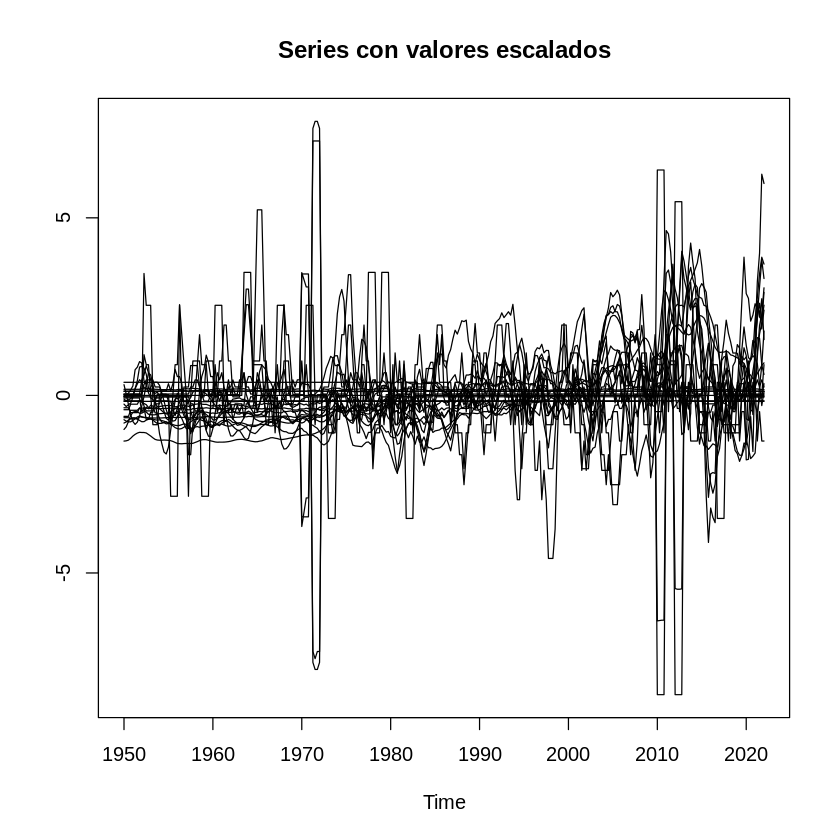

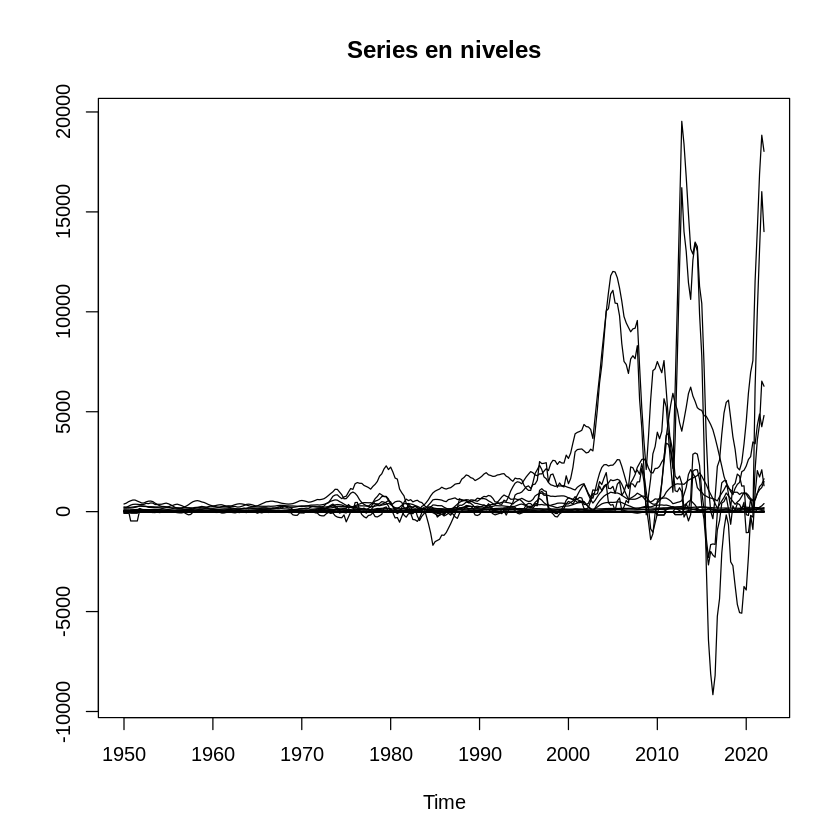

In [17]:
df_cleaned <- new_df.cleaned
total_na <- sum(is.na(df_cleaned))
print(paste0("Una vez completado el llenado de los valores faltantes la cantidad de NA es de: ",total_na))

# Get the indices of elements containing '4quarters'
indices <- grep("4quarters", colnames(df_cleaned))

# Print the matched words
df_selected <- ts(df_cleaned[indices],start=c(year(df_cleaned$date[1]),month(df_cleaned$date[1])),frequency=4)

df_selected |> head()

ts.plot(scale(df_selected), main= "Series con valores escalados")
ts.plot(df_selected, main= "Series en niveles")

### Presentación de la variable objetivo
A continuación se muestra las variables que se incluyen en el set de datos, de todas estas, la variable objetivo seleccionada para este experiento es *Private_inventories__Farm4quarters* la cual corresponde a un índice generado para medir los inventarios de los granjeros en manos del sector privado. Esta variable, como las demás, han sido transformadas a una media movil de cuatro cuartos, de esta manera la variable ha sido suavizada. El objetivo personal de este ejercicio es predecir la variable en nivel haciendo uso de las demás variables reducidas en sus tres principales elementos.
#### Descomposición
A continuación se hace una descomposición aditiva de la variable a predecir.

,colnames.df_selected.
,<chr>
1,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation4quarters
2,Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Revaluation4quarters
3,Corporate_Farm_Business__Farm_Mortgages__Liability__Revaluation4quarters
4,Corporate_Farm_Business__Insurance_Receivables_Due_from_Property_Casualty_Insurance_Companies__Asset__Revaluation4quarters
5,Corporate_Farm_Business__Inventories__Revaluation4quarters
6,Corporate_Farm_Business__Loans__Liability__Revaluation4quarters


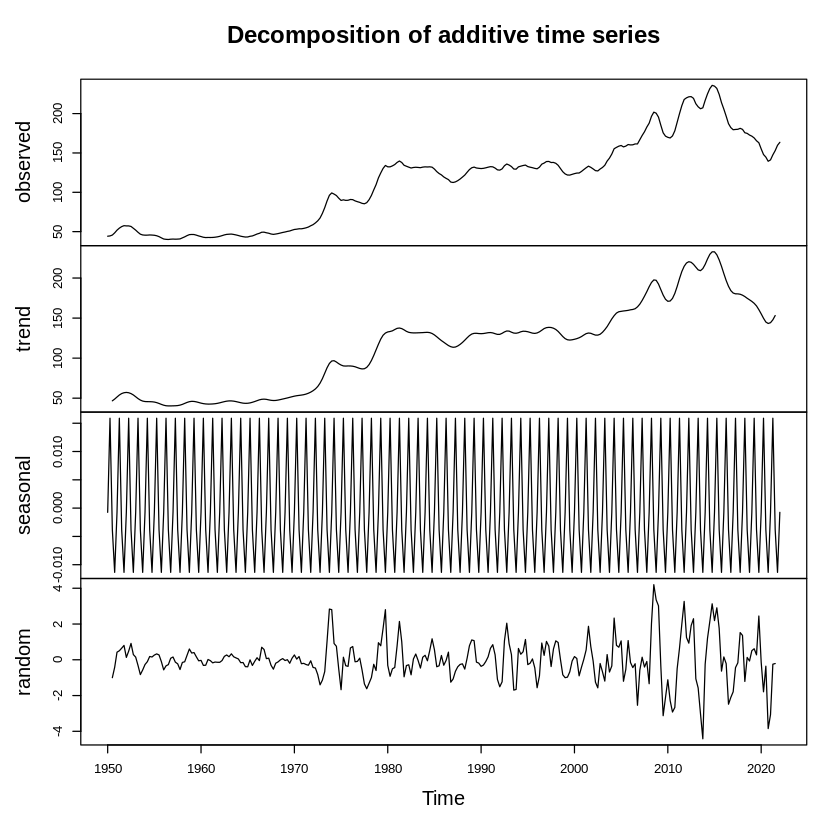

In [18]:
colnames(df_selected) |> data.frame() |> head()
target_variable <- "Private_inventories__Farm4quarters"
plot(decompose(df_selected[,target_variable]))

# Reducción de la dimensionalidad
A continuación se realizan distintos análisis de correlaciones, con el objetivo de obtener un conjunto de variables mas acotado.


In [19]:
Correlation_Matrix <-  as.data.frame(cor(df_selected))
Correlation_Matrix |> head()

Warning message in cor(df_selected):
“the standard deviation is zero”


,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation4quarters,Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Revaluation4quarters,Corporate_Farm_Business__Farm_Mortgages__Liability__Revaluation4quarters,Corporate_Farm_Business__Insurance_Receivables_Due_from_Property_Casualty_Insurance_Companies__Asset__Revaluation4quarters,Corporate_Farm_Business__Inventories__Revaluation4quarters,Corporate_Farm_Business__Loans__Liability__Revaluation4quarters,Corporate_Farm_Business__Net_Lending_____or_Borrowing______Financial_Account___Revaluation4quarters,Corporate_Farm_Business__Nonfinancial_Assets__Revaluation4quarters,Corporate_Farm_Business__Nonresidential_Entertainment__Literary__and_Artistic_Originals__Current_Cost_Basis__Revaluation4quarters,Corporate_Farm_Business__Nonresidential_Software__Current_Cost_Basis__Revaluation4quarters,⋯,Households_and_Nonprofit_Organizations__Farm_Mortgages__Asset__Revaluation4quarters,Personal_Sector__Commercial__Multifamily__and_Farm_Mortgages__Liability__Revaluation4quarters,Private_inventories__Farm4quarters,Proprietors__Farm_Income_in_Maine4quarters,Proprietors__Farm_Income_in_Mississippi4quarters,Proprietors__Farm_Income_in_Nebraska4quarters,Proprietors__Farm_Income_in_New_Jersey4quarters,Proprietors__Farm_Income_in_Pennsylvania4quarters,Proprietors__Farm_Income_in_South_Carolina4quarters,Proprietors__Farm_Income_in_Wyoming4quarters
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation4quarters,1.00000000,0.019630672,0.020274516,0.0000000000,-0.040336437,0.0287328981,-0.042577104,-0.05642730,NA,0.05625617,⋯,NA,-0.020274516,-0.18071152,0.02801227,-0.08903399,-0.11338185,-0.11785201,-0.10581355,-0.04689931,-0.041946230
Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Revaluation4quarters,0.01963067,1.000000000,-0.006636885,-0.0010648657,-0.145618401,0.6468486737,-0.019504222,-0.26507963,NA,-0.04333101,⋯,NA,0.006636885,-0.23503954,-0.22304396,0.01739481,-0.29637363,-0.16482593,-0.30100671,-0.05323439,-0.083840364
Corporate_Farm_Business__Farm_Mortgages__Liability__Revaluation4quarters,0.02027452,-0.006636885,1.000000000,0.0454424106,-0.004561254,0.0390783375,-0.940611965,0.01914433,NA,-0.01931907,⋯,NA,-1.000000000,0.04471004,0.07011953,0.02997959,0.04090892,0.06417232,0.04464376,0.02885753,0.003304352
Corporate_Farm_Business__Insurance_Receivables_Due_from_Property_Casualty_Insurance_Companies__Asset__Revaluation4quarters,0.00000000,-0.001064866,0.045442411,1.0000000000,0.039836181,-0.0001165351,0.009671069,0.03758513,NA,0.01988692,⋯,NA,-0.045442411,-0.12052809,-0.08728580,-0.04736028,-0.09217486,-0.08608953,-0.04290674,0.02143245,-0.040365398
Corporate_Farm_Business__Inventories__Revaluation4quarters,-0.04033644,-0.145618401,-0.004561254,0.0398361810,1.000000000,-0.2342694418,-0.019211873,0.59870390,NA,-0.07377672,⋯,NA,0.004561254,0.27087818,0.25552628,0.30108837,0.31454234,0.09904222,0.36300975,0.33451338,0.112511895
Corporate_Farm_Business__Loans__Liability__Revaluation4quarters,0.02873290,0.646848674,0.039078338,-0.0001165351,-0.234269442,1.0000000000,-0.066465687,-0.24188290,NA,-0.00450873,⋯,NA,-0.039078338,-0.24950905,-0.32524941,-0.01645463,-0.25848350,-0.13014988,-0.22847882,-0.13797685,0.052043876


### Selección de variables
Se seleccionan las variables que etén correlacionado en mas del 40% con la variable a predecir.

In [20]:
Correlation_Matrix <- Correlation_Matrix |>
  filter(!is.na(!!sym(target_variable))) |>
  filter(abs(!!sym(target_variable)) >= .40 & abs(!!sym(target_variable)) != 1)

matriz <- as.data.frame(Correlation_Matrix[, target_variable], row.names = rownames(Correlation_Matrix))
colnames(matriz) <- paste0(target_variable)

print(matriz)

                                                                                Private_inventories__Farm4quarters
Corporate_Farm_Business__Nonfinancial_Assets__Revaluation4quarters                                       0.4178811
Corporate_Farm_Business__Real_Estate__Revaluation4quarters                                               0.6484058
Corporate_Farm_Business__Total_Capital_Expenditures__Net___Revaluation4quarters                          0.4481635
Proprietors__Farm_Income_in_Maine4quarters                                                               0.4869849
Proprietors__Farm_Income_in_Mississippi4quarters                                                         0.6184228
Proprietors__Farm_Income_in_Nebraska4quarters                                                            0.8062037
Proprietors__Farm_Income_in_New_Jersey4quarters                                                          0.4743330
Proprietors__Farm_Income_in_Pennsylvania4quarters                               

### Generación de la variable objetivo y sus variables regresoras
En esta etapa seleccionamos e vector a predecir y la matriz de regresoras.

In [21]:
target <- df_selected[,target_variable]
xreg <- df_selected[,rownames(Correlation_Matrix)]

target |> head()
xreg |> head()

,Qtr1,Qtr2,Qtr3,Qtr4
1950,44.21375,44.56225,45.68250,48.45200
1951,51.88725,54.46650,,


,Corporate_Farm_Business__Nonfinancial_Assets__Revaluation4quarters,Corporate_Farm_Business__Real_Estate__Revaluation4quarters,Corporate_Farm_Business__Total_Capital_Expenditures__Net___Revaluation4quarters,Proprietors__Farm_Income_in_Maine4quarters,Proprietors__Farm_Income_in_Mississippi4quarters,Proprietors__Farm_Income_in_Nebraska4quarters,Proprietors__Farm_Income_in_New_Jersey4quarters,Proprietors__Farm_Income_in_Pennsylvania4quarters
1950 Q1,61,45,-81,85.175,187.200,383.350,84.400,238.450
1950 Q2,61,45,-81,76.075,214.075,423.175,81.425,223.975
1950 Q3,61,45,-81,66.100,268.875,495.925,83.725,216.500
1950 Q4,-465,-78,85,56.350,328.500,544.300,85.550,217.150
1951 Q1,-465,-78,85,49.750,364.025,582.950,92.650,231.225
1951 Q2,-465,-78,85,46.975,371.725,580.100,103.400,248.900


### Reducción de la dimensión
El paso es cnvertir en matriz a XREG, que es un set de datos con 9 columnas, una vez convertido en matriz, se genera la extracción de los principales componentes. De estos componentes, se seleccionan los 3 primeros para ser utilizado en los distintos modelos explorados.


In [22]:
ts_matrix <- embed(xreg)

pca <- prcomp(ts_matrix)

xreg_reduced <- scale(pca$x[,1:3])
xreg_reduced |> head()

PC1,PC2,PC3
-0.5416728,0.6179655,-0.26274089
-0.5404025,0.6060907,-0.22737313
-0.5378699,0.5830515,-0.15815536
-0.6098162,0.3647202,-0.11017079
-0.6082643,0.3512019,-0.06912303
-0.6081320,0.3506836,-0.06762297


#Entrenamiento de los modelos
Como primer paso se generan los primeros modelos univariados que luego serán presentados juntos a los modelos multivariados (solamente se presentará el modelo arima).

### Modelos univariados

In [23]:
# Load the necessary library
library(forecast)

# Function to fit and forecast with multiple models
multi_model_forecast <- function(target) {

  # Fit ARIMA model
  fit.arima <- auto.arima(target, stepwise=F, lambda=T, parallel = T, num.cores = 4)

  # Fit BAGGED model
  fit.baggedModel <- baggedModel(target, bootstrapped_series = bld.mbb.bootstrap(target, 100))

  # Fit NNETAR model
  fit.nnetar <- nnetar(target, parallel = T, num.cores = 4)

  # Produce forecasts for ARIMA
  forecasts.arima <- forecast(fit.arima, h = 100, level = c(16, 68))$mean[1:100]

  # Produce forecasts for BAGGED
  forecasts.baggedModel <- forecast(fit.baggedModel, h = 100, level = c(16, 68))$mean[1:100]

  # Produce forecasts for NNETAR
  forecasts.nnetar <- forecast(fit.nnetar, h = 100, level = c(16, 68))$mean[1:100]

  # Return list of forecasts
  return(list(arima = forecasts.arima, nnetar = forecasts.nnetar,baggedModel = forecasts.baggedModel))
}

results <- multi_model_forecast(target)

# División de Datos en Series Temporales

Al trabajar con series temporales, es común dividir los datos en dos conjuntos:

* Conjunto de entrenamiento
* Conjunto de validación (también conocido como backtesting)

La idea es entrenar tu modelo en una parte de los datos (el conjunto de entrenamiento) y luego probar su rendimiento en una parte no vista de los datos (el conjunto de validación).

## Generación de función de rolling window

In [30]:
predicciones_rolling_auto = function(window,
                                     h, # horizonte predicción
                                     serie,
                                     frequency) {
  library(forecast)
  predicciones=NULL;
  cortar= length(serie)-window
  rolling=cortar:length(serie)
  print("Starting Process")
  for( i in rolling){
    x=NULL;
    x=ts(serie[1:i],frequency=frequency);
    predicted=forecast(auto.arima(x), h)[["mean"]];
    predicciones=append(predicciones,predicted);
    # Printing Progress
    ###print(paste0("Progress: ",format(((i+1-rolling[1])/(length(rolling)))*100),"%"),nsmall=2)
  }
  date=data.frame(Fecha=(format(index(serie)[which(serie[rolling[2]]==serie)],nsmall=2)));
  date=data.frame(c(strsplit(date$Fecha,"." , fixed = TRUE)));
  date[2,]=paste0(0,".",date[2,]);
  start.testing.hat=c(as.numeric(date[1,]),ifelse((round(as.numeric(date[2,])*12)+1)<10,
                                                  paste0(0, (round(as.numeric(date[2,])*12)+1)),
                                                  round(as.numeric(date[2,])*12)));
  start.testing=c(as.numeric(date[1,]),ifelse(round(as.numeric(date[2,])*12)<10,
                                              paste0(0, round(as.numeric(date[2,])*12)),
                                              round(as.numeric(date[2,])*12)));
  y_hat=ts(predicciones,start = start.testing.hat,frequency=frequency);
  y=ts(serie[rolling[1]:rolling[length(rolling)]],start = start.testing,frequency=frequency);
  error.puntual=y_hat/y-1;
  error.cum=ts(cumsum(error.puntual),start = start.testing.hat,frequency=frequency);
  # Guardando los resultados
  ts.predicciones<<-cbind(y_hat,
                          y,
                          error.puntual,
                          error.cum)
}

# Generando las predicciones a un horizonte de 1 para ver cómo ajusta el modelo univariado.

In [31]:
# ARIMA auto
prediccion=predicciones_rolling_auto(
  window = 80,
  h=1,
  serie = target,
  frequency = 4)

[1] "Starting Process"


### Grafico del rolling window prediciendo a 1 periodo



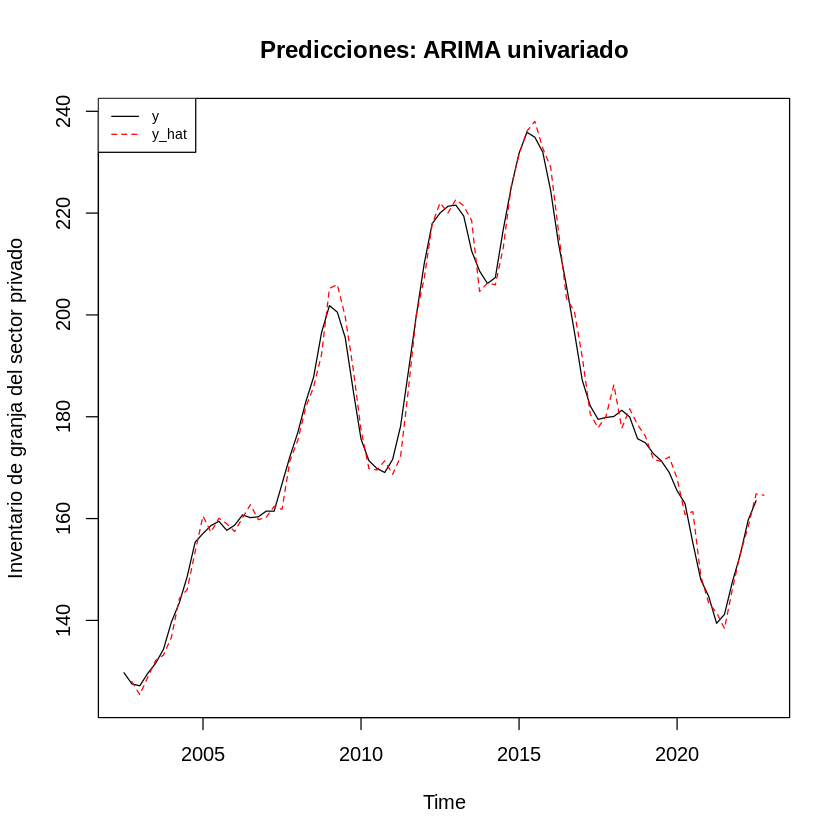

In [32]:
plot.ts(prediccion[,"y"],
        main="Predicciones: ARIMA univariado",
        ylab="Inventario de granja del sector privado",
        ylim=c(min(append(prediccion[,"y_hat"],prediccion[,"y"]),na.rm = T),
               max(append(prediccion[,"y_hat"],prediccion[,"y"]),na.rm = T)));lines(prediccion[,"y_hat"],col="red",type="l",lty=2)
legend("topleft", legend=c("y", "y_hat"),
       col=c("black", "red"), lty=c(1,2), cex=0.7,
       box.lty=1, box.lwd=1, box.col="black")


## Validación
Generación de la matriz para validar los forecasts a 4 instancias. Se omitirán las 100 instancias en la validación y solamente se realizará al final como predicciones a futuro.

La idea es probar los distintos modelos en capacidad predictiva de 4 instancias, donde la muestra va adquiriendo innovaciones y generando predicciones que luego serán comparadas a las realizaciones. De esta manera se podrá construir 2 métricas para medir la precisión, una es MASE y la otra el MAPE. La primera lo compara contra un modelo naive, siendo el valor menor a 1 la indicación de que es mejor en capacidad predictiva a un modelo naive. Con respecto al MAPE, nos permitirá conocer el valor absoluto promedio del error, que podríamos decir en qué proporción erra el modelo.

La siguiente gráfica busca expresar la metodología a utilizar.
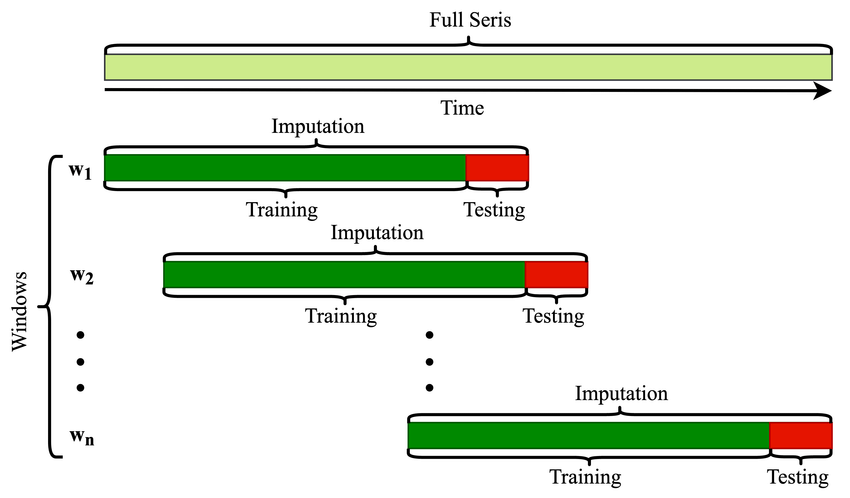


In [33]:
window=78
Comparar=c(target[(length(target)-(window+3)):length(target)])
Matriz=cbind(Comparar,
             lead(Comparar),
             lead(Comparar,2),
             lead(Comparar,3),
             lead(Comparar,4))

Matriz=Matriz[1:window,]


Generando las predicciones para la validación del modelo arima

In [34]:
prueba_arima=matrix(0,ncol=4,nrow=window);
for( i in 1:window){
      y=NULL
      y=ts(target[1:(length(target)-82+i)],frequency=4)
      predicted=matrix(c(forecast(auto.arima(y), 4)[["mean"]][1:4]),ncol=4);
      prueba_arima[i,]=predicted;
}

### Modelos Multivariados

SARIMAX o ARIMAX, todo depende del componente estacional, si posee se denominará SARIMAX.

In [35]:
prueba_arimax=matrix(0,ncol=4,nrow=window);
for( i in 1:window){
      y=NULL;
      x=NULL
      y=ts(target[1:(length(target)-82+i)],frequency=4);
      x=ts(xreg_reduced[1:(length(target)-82+i),],frequency=4)
      predicted=matrix(c(forecast(auto.arima(y,xreg=x), xreg = x,4)[["mean"]][1:4]),ncol=4);
      prueba_arimax[i,]=predicted;
}

In [36]:
# Generación del set de datos
data_blended.ts <- ts(cbind(target,xreg_reduced),start=c(1950,01),frequency=4)

#### Modelo GARCH
El modelo GARCH (Modelos Autoregresivos de Heterocedasticidad Condicional Generalizada) es una herramienta estadística utilizada para predecir volatilidades futuras a partir de series temporales de datos pasados.
La variable a predecir alimentará el modelo sin ser transformada, es decir, será utilizada en niveles. Se utiliza como variable regresora a los 3 componentes principales de las 8 series seleccionadas.

In [37]:
# Load the necessary library
library(fGarch)

# Define your data here
data <- data_blended.ts

# Fit a GARCH(1,1) model as a starting point
fit.garch_100<- suppressWarnings(garchFit(target ~ garch(1, 1), data = data, trace = FALSE))

# Check the summary of the fitted model
#summary(fit.garch.100)

# Produce forecasts
forecasts.garch_100 <- predict(fit.garch_100, n.ahead = 100)

forecasts.garch_100 |> head()

,meanForecast,meanError,standardDeviation
,<dbl>,<dbl>,<dbl>
1,131.7318,31.80654,31.80654
2,131.7318,31.84030,31.84030
3,131.7318,31.87402,31.87402
4,131.7318,31.90770,31.90770
5,131.7318,31.94136,31.94136
6,131.7318,31.97497,31.97497


In [38]:
prueba_GARCH=matrix(0,ncol=4,nrow=window);
for( i in 1:window){
      x=NULL
      x=ts(data_blended.ts[1:(length(target)-82+i),],frequency=4)
      predicted=matrix(c(predict(suppressWarnings(garchFit(target ~ garch(1, 1), data = x, trace = FALSE)), n.ahead = 4)$meanForecast),ncol=4);
      prueba_GARCH[i,]=predicted;
}

In [39]:
install.packages("Metrics",dependencies = T)
library(Metrics)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy




##### Gaficamos las predicciones de 100 futuras intancias
El siguiente gráfico muestra las predicciones a 100 instancias del modelo GARCH generado por la variable objetivo y los 3 componentes principales de las variables regresoras.
mase(forecasts.garch)

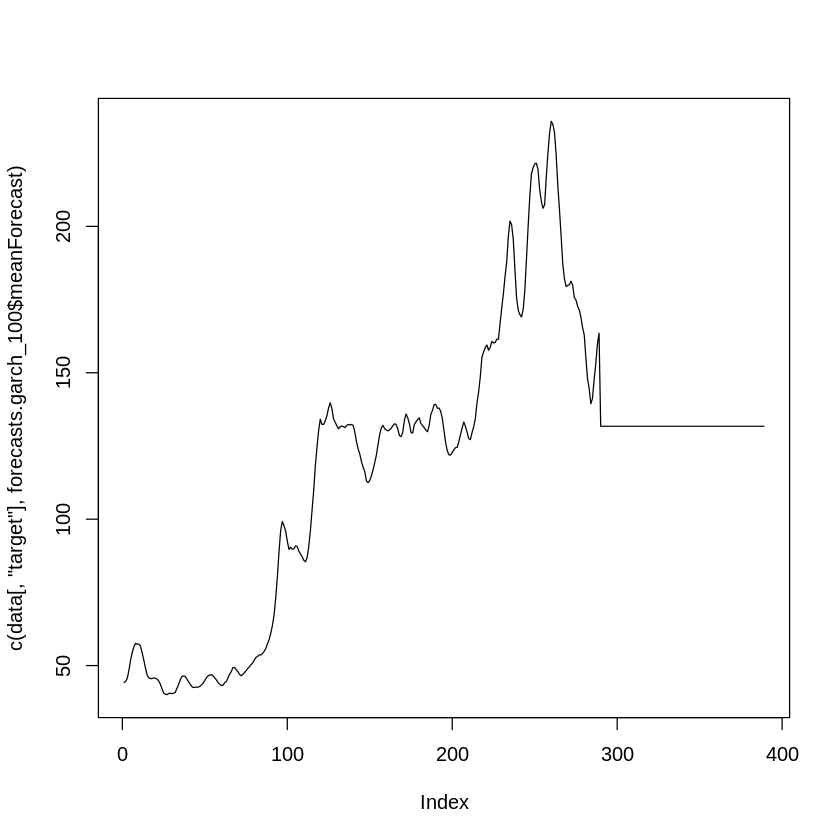

In [42]:
# Plot the original data
plot(c(data[,"target"],forecasts.garch_100$meanForecast),type="l")

#### Modelo VAR
El modelo VAR (Vector Autoregressive Model) es un tipo de modelo estadístico que utiliza una serie temporal de observaciones propias, sus lags y variables regresoras para predecir valores en el futuro.
No se realizará interpretación de los parámetros obtenidos. Se recomienda hacer un análisis de mayor profundidad en estos modelos y ver si realmente son pertinentes. En este ejercicio solamente se busca aplicar el modelo y generar predicciones de 100 instancias a futuro.

AIC(n) 
     4

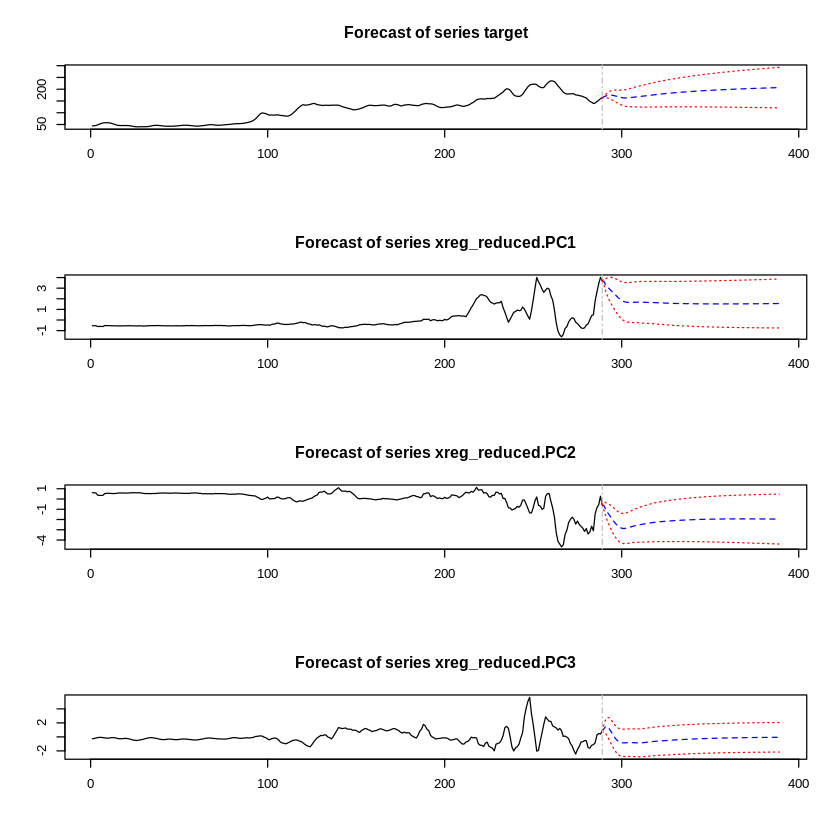

In [43]:
# Fit a VAR model
parameters.var.selected <- VARselect(data_blended.ts, lag.max = 4, type = c("const", "trend", "both", "none"))
fit.var_100 <- VAR(data_blended.ts, p = parameters.var.selected$selection[1] ) # Utilizaremos la métrica de AIC(n): 5
parameters.var.selected$selection[1]

# Forecast next 10 steps
forecasts.var_100 <- predict(fit.var_100, n.ahead = 100)

plot(forecasts.var_100)

In [44]:
prueba_VAR=matrix(0,ncol=4,nrow=window);
for( i in 1:window){
      x=NULL
      x=ts(data_blended.ts[1:(length(target)-82+i),],frequency=4)
      parameters.var.selected <- VARselect(x, lag.max = 4, type = c("const", "trend", "both", "none"))
      fit.var <- VAR(x, p = parameters.var.selected$selection[1] ) # Utilizaremos la métrica de AIC(n): 5


      predicted=matrix(c(predict(fit.var, n.ahead = 4)$fcst$target[,1]),ncol=4);
      prueba_VAR[i,]=predicted;
}

# Generación del data set para el último modelo

In [45]:
data_blended.ts <- ts(cbind(c(target,rep(NA,100)),
    rbind(xreg_reduced,cbind(PC1=rep(NA,100),PC2=rep(NA,100),	PC3=rep(NA,100)))),
    start=c(1950,1),frequency=4)

## Modelo Arima Multivariado
Los modelos ARIMA, en su versión SARIMAX, que incluyen estacionalidad y variables exógenas son muy populares, una forma de aplicar este tipo de modelos es mediante la función auto.arima() de la librería forecast que permite cargar variables regresoras dentro del argumento XREG de su función. Se resalta que la variable ingresa en niveles en el modelo y es así como se va a predecir, en niveles, con respecto a sus regresoras, estas son los 3 principales componentes que se utilizó en el modelo anterior.


In [46]:
# Define the indices to exclude from target and exogenous regressors
exclusion_indices <- -c((length(target)+1):(length(target)+100))

# Create a time series for the exogenous regressors, excluding some observations
X <- ts(data_blended.ts[exclusion_indices, -1],
        start=c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
        frequency=4)

# Create a time series for all observations of the exogenous regressors
X.2 <- ts(data_blended.ts[, -1],
          start=c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
          frequency=4)

# Fit an ARIMA model to the time series data (excluding some observations)
# with additional regressors included in the model.
# Then, generate forecasts for the fitted model using X.2 as xreg
forecast.sarimax <- suppressWarnings(forecast::forecast(
    forecast::auto.arima(ts(data_blended.ts[exclusion_indices, 1],
                            start=c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
                            frequency=4),
    xreg = X),
    xreg = X.2)$mean[1:100])

#Selección del mejor modelo

El Mean Absolute Scaled Error (MASE) es una métrica utilizada en estadísticas para medir la precisión de los métodos de pronóstico. Se calcula como:

```python
MASE = mean(abs(y - y_hat)) / mean(abs(y - lag(y)))
```

Donde:
- `y` es el valor actual,
- `y_hat` es el valor predicho, y
- `lag(y)` es el valor anterior en la serie de tiempo.

MASE escala el error medio absoluto con respecto al error de un método de pronóstico naive, que simplemente pronostica el siguiente punto de datos como el último observado. Un MASE menor a 1 indica que el modelo de pronóstico tiene mejor rendimiento que el método naive.

* **En la muestra** el mejor modelo por capacidad predictiva dentro de la muestra es el SARIMAX, el modelo autoregressivo que incluye regresoras, y además busca capturar una estacionalidad en los datos.
* **Fuera de la muestra o en validación** el mejor modelo de capacidad predictiva para horizontes de 1 a 3 cuartos es el modelo VAR, sin considerar al ARIMA univariado. Cuando corresponde a 4 cuartos, el mejor modelo es el ARIMAX.

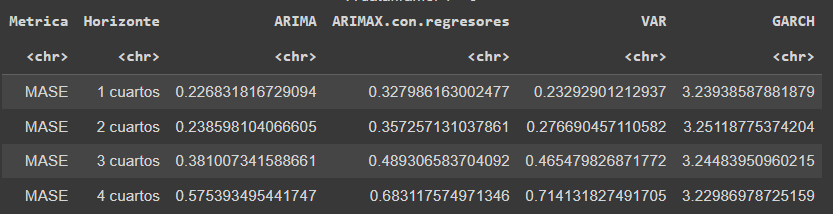

## In sample o en la muestra
El modelo ARIMAX tiene mayor capacidad predictiva haciendo uso de la métrica MASE

In [47]:
mod.sarimax <-forecast::auto.arima(y=ts(data_blended.ts[exclusion_indices, 1],
                            start=c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
                            frequency=4),
    xreg = X)


mod.arima <-forecast::auto.arima(y=ts(data_blended.ts[exclusion_indices, 1],
                            start=c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
                            frequency=4))

print(paste0("arima MASE: ", mase(mod.arima$fitted,mod.sarimax$x)))
print(paste0("arimax MASE: ", mase(mod.sarimax$fitted,mod.sarimax$x)))
print(paste0("GARCH MASE: ", mase(mod.sarimax$x+residuals(fit.garch_100),mod.sarimax$x))) # Este modelo tien nula capacidad predictiva
print(paste0("VAR MASE: ", mase(imputeTS::na_ma(c(rep(NA,4),fit.var_100$varresult$target$fitted.values)),mod.sarimax$x))) # Este modelo tien nula capacidad predictiva

[1] "arima MASE: 0.359354939712438"
[1] "arimax MASE: 0.299595231275395"
[1] "GARCH MASE: 9.89199790105773"
[1] "VAR MASE: 0.441002350317167"


## Generación de las tablas finales

In [48]:

MAPE=NULL
for (i in 1:4){
  MAPE=data.frame(rbind(MAPE,c("Metrica"="MAPE",
                                 "Horizonte"=paste0(i," cuartos"),
                                 "ARIMA "=mape (Matriz[,i],prueba_arima[,i]),
                                 "ARIMAX con regresores"=mape (Matriz[,i],prueba_arimax[,i]),
                                 "VAR"=mape(Matriz[,i],prueba_VAR[,i]),
                                 "GARCH"=mape(Matriz[,i],prueba_GARCH[,i]))))
}

MASE=NULL
for (i in 1:4){
  MASE=data.frame(rbind(MASE,c("Metrica"="MASE",
                               "Horizonte"=paste0(i," cuartos"),
                               "ARIMA"=mase(Matriz[,i],prueba_arima[,i],step_size = 4),
                               "ARIMAX con regresores"=mase(Matriz[,i],prueba_arimax[,i],step_size = 4),
                               "VAR"=mase(Matriz[,i],prueba_VAR[,i],step_size = 4),
                               "GARCH"=mase(Matriz[,i],prueba_GARCH[,i],step_size = 4))))
}

In [49]:
MASE
MAPE

Metrica,Horizonte,ARIMA,ARIMAX.con.regresores,VAR,GARCH
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
MASE,1 cuartos,0.226831816729094,0.327986163002477,0.23292901212937,3.23938587881879
MASE,2 cuartos,0.238598104066605,0.357257131037861,0.276690457110582,3.25118775374204
MASE,3 cuartos,0.381007341588661,0.489306583704092,0.465479826871772,3.24483950960215
MASE,4 cuartos,0.575393495441747,0.683117574971346,0.714131827491705,3.22986978725159


Metrica,Horizonte,ARIMA.,ARIMAX.con.regresores,VAR,GARCH
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
MAPE,1 cuartos,0.0187190362011205,0.0286297061857585,0.0191560889858054,0.253124406258709
MAPE,2 cuartos,0.01978533777956,0.0305193434834828,0.023072862242861,0.253825011220177
MAPE,3 cuartos,0.0317115273488941,0.0409516110698209,0.0396433876000166,0.254991835926755
MAPE,4 cuartos,0.0482202831162957,0.057129214440517,0.061910989282179,0.257211655201462


# Predicción a 100 instancias
A continuación se realizan los forecasts para un horizonte de 100. El modelo que a largo plazo genera la mejor prediccion es el modelo ARIMAX, aunque los modelos VAR en el corto plazo (menor a 4 cuartos) tienen mayor capacidad predictiva haciendo uso de la métrica MASE.

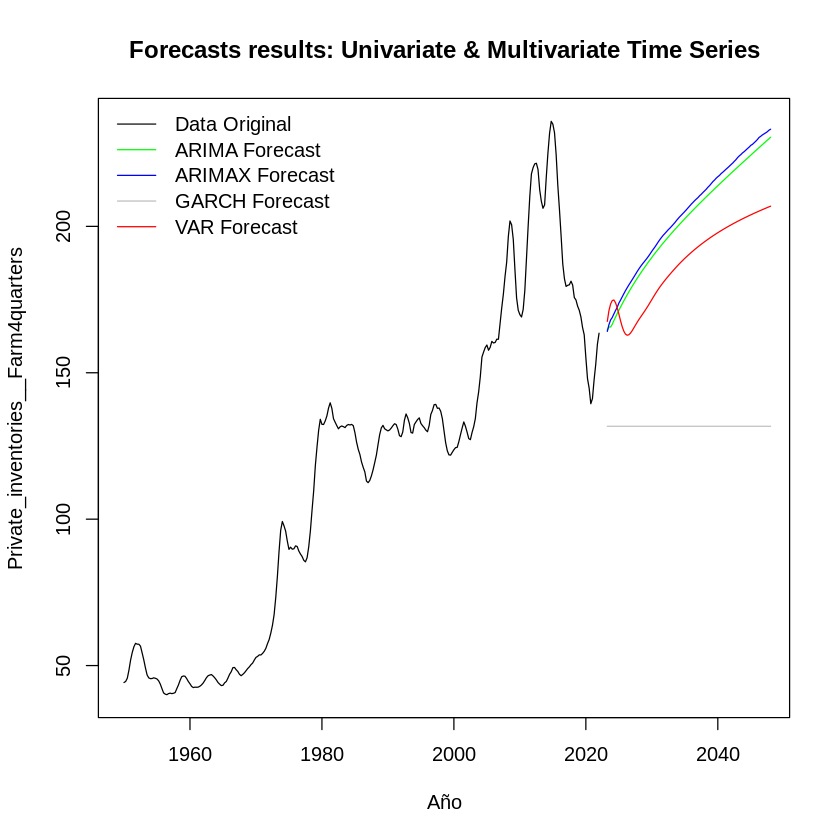

In [51]:
plot(ts(c(target,rep(NA,100)),start=c(year(df_cleaned$date[1]),month(df_cleaned$date[1])),frequency=4),
    main="Forecasts results: Univariate & Multivariate Time Series",
    ylab=target_variable,
    xlab="Año",type="l")

lines(ts(c(rep(NA,293),results$arima),start=c(year(df_cleaned$date[1]),month(df_cleaned$date[1])),frequency=4),col="green")
lines(ts(c(rep(NA,293),forecast.sarimax),start=c(year(df_cleaned$date[1]),month(df_cleaned$date[1])),frequency=4),col="blue")
lines(ts(c(rep(NA,293),forecasts.garch_100$meanForecast),start=c(year(df_cleaned$date[1]),month(df_cleaned$date[1])),frequency=4),col="grey")
lines(ts(c(rep(NA,293),forecasts.var_100$fcst$target[,1]),start=c(year(df_cleaned$date[1]),month(df_cleaned$date[1])),frequency=4),col="red")

# Add legend to the plot
legend("topleft", legend = c("Data Original", "ARIMA Forecast","ARIMAX Forecast","GARCH Forecast","VAR Forecast"),
col = c("black", "green", "blue","grey","red"), lty = c(1,1,1, 1, 1), bty = "n")